In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/GAN/Shipibo GAN/")
!ls

KeyboardInterrupt: ignored

In [0]:

!mkdir imgs_64
!unzip -q preproc/64/0_Compressed_64.zip -d imgs_64/

'\n!mkdir imgs_64\n!unzip -q preproc/64/0_Compressed_64.zip -d imgs_64/\n'

In [0]:
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image

def load_images(path,size=64,final_size=5000):
    """ loads images into a numpy array and returns them
    """
    img_paths = [path + f  for f in os.listdir(path)]
    print(len(img_paths))
    dataset_shape = (final_size ,size,size,3)

    data = np.ndarray(shape=dataset_shape)

    for i,f in enumerate(img_paths):
        with Image.open(f) as im:
            
            im = np.array(im)
            
            if i % 500 == 0:
                print("loaded ", i,"images" )

            data[i] = im.astype(int)

            if (i+1) % final_size == 0:

                return data
            
        

    print(data.shape)

    return data

data = load_images("imgs_64/",size=64,final_size=10000)


Using TensorFlow backend.


24479
loaded  0 images


In [0]:
#warning, only run this once or else load the data all over again
data = (data - 127.5) / 127.5



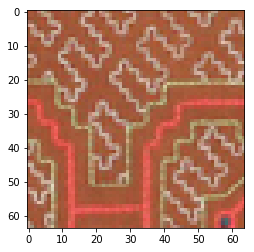

In [0]:
test = (data[0] + 1) / 2.0
plt.imshow(test)

In [0]:
def generate_real_samples(data,n_samples):
    
    rand_indexes = np.random.randint(0,data.shape[0],n_samples)
    
    X_samples = data[rand_indexes]
    y_samples = np.ones((n_samples,1))
    
    return X_samples,y_samples

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.optimizers import Adam

def make_discriminator(input_shape=(64,64,3)):
    
    model = Sequential()
    #normal layer
    model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #flatten then pass through fully connected layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    
    opt = Adam(lr=0.0002,beta_1=0.5)
    
    model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

    model.summary()
    
    return model

In [0]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

# define the standalone generator model
def make_generator(latent_dim=100):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

    model.summary()
    
    return model


In [0]:
def generate_latent_points(n_samples,latent_dim=100):
    
    latent_points = np.random.randn(latent_dim*n_samples)
    
    latent_points = latent_points.reshape((n_samples,latent_dim))
    
    return latent_points

def generate_fake_samples(generator,n_samples,latent_dim=100):
    
    #first generate latent points, then pass them to the generator
    
    latent_points = generate_latent_points(n_samples,latent_dim)
    
    X_fake = generator.predict(latent_points)
    
    y_fake = np.zeros((n_samples,1))
    
    return X_fake,y_fake

In [0]:
def make_gan(discriminator,generator):
    
    model = Sequential()
    
    discriminator.trainable = False
    
    model.add(generator)
    
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    
    return model


In [0]:
discriminator = make_discriminator()
generator = make_generator()

gan = make_gan(discriminator,generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)         295168    
__________

In [0]:
import time

def train_gan(data,gan,discriminator,generator,n_epochs=200,batch_size=128):
    batch_per_epoch = int(data.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    n_points = 9
    fixed_latent_points = generate_latent_points(n_points)
    train_images = []
    
    gan_loss = []
    disc_loss = []
    
    
    for epoch in range(n_epochs):
        print("starting epoch",epoch)
        start_time = time.time()
        
        avg_epoch_disc_loss= []
        avg_epoch_gen_loss = []

        for batch in range(batch_per_epoch):
            
            #train the discriminator
            X_real,y_real = generate_real_samples(data,half_batch)
            X_fake,y_fake = generate_fake_samples(generator,half_batch)
            
            X,y = np.vstack((X_real,X_fake)) , np.vstack((y_real, y_fake))
            
            d_loss, _ = discriminator.train_on_batch(X,y)
            
            #train the generator (through the gan model by using the discriminator's error)
            lat_points = generate_latent_points(batch_size)
            y_gan = np.ones((batch_size,1))
            
            g_loss = gan.train_on_batch(lat_points,y_gan)
            
            
            #paint some pictures
            if batch % 5 == 0:
                imgs = generator.predict(fixed_latent_points)

                #renormalize images for easy printing
                imgs = (imgs + 1) / 2.0
                train_images.append(imgs)
                
                #add loss to storage for graphing
                
                gan_loss.append(g_loss)
                disc_loss.append(d_loss)
            
            avg_epoch_disc_loss.append(d_loss)
            avg_epoch_gen_loss.append(g_loss)

        stop_time = time.time()
        print("avg loss over epoch, \nDiscriminator:" ,sum(avg_epoch_disc_loss)/len(avg_epoch_disc_loss),"\nGenerator:",sum(avg_epoch_gen_loss)/len(avg_epoch_gen_loss))
        print("epoch",epoch,"finished in",stop_time - start_time,"s\n\n")
            
            
    return train_images,gan_loss,disc_loss


reset_train = False

if reset_train:    
    discriminator = make_discriminator()
    generator = make_generator()

    gan = make_gan(discriminator,generator)



train_images,gan_loss,disc_loss = train_gan(data,gan,discriminator,generator,n_epochs=50)            
            
     

starting epoch 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


avg loss over epoch, 
Discriminator: 0.15992558915265567 
Generator: 4.080843580954986
epoch 0 finished in 115.87532496452332 s


starting epoch 1
avg loss over epoch, 
Discriminator: 0.15204112011334658 
Generator: 4.184066596455599
epoch 1 finished in 115.82874512672424 s


starting epoch 2
avg loss over epoch, 
Discriminator: 0.14102990275824256 
Generator: 4.2398876931654845
epoch 2 finished in 115.60572862625122 s


starting epoch 3


E0818 13:53:43.795849 139784176904064 ultratb.py:152] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-4bb19e780460>", line 73, in <module>
    train_images,gan_loss,disc_loss = train_gan(data,gan,discriminator,generator,n_epochs=50)
  File "<ipython-input-26-4bb19e780460>", line 30, in train_gan
    d_loss, _ = discriminator.train_on_batch(X,y)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1217, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_fn(*array_vals)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1458, in __call

KeyboardInterrupt: ignored

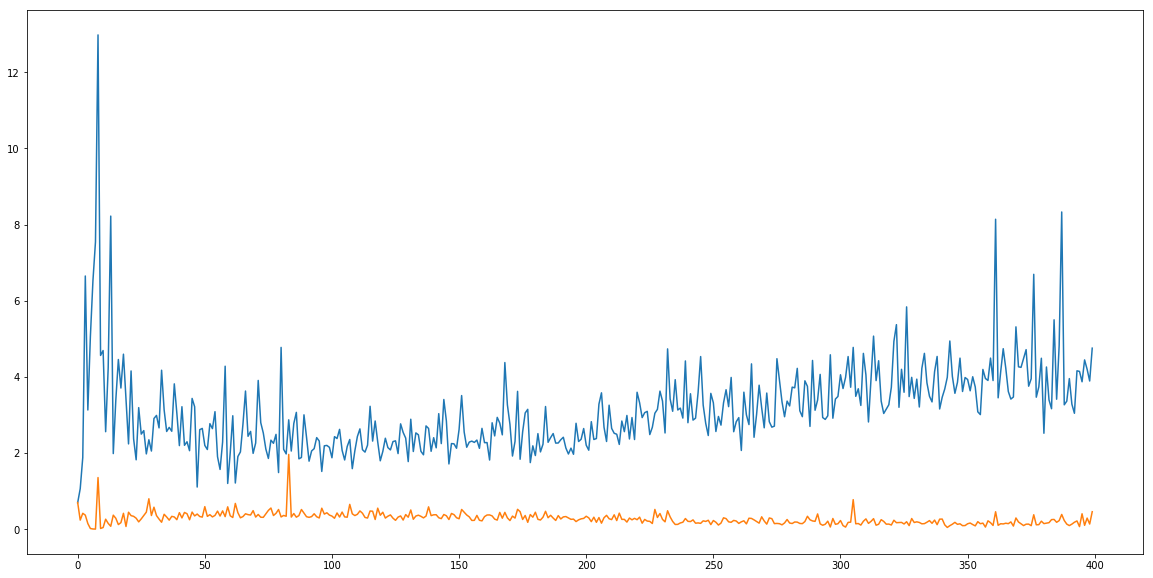

In [0]:
plt.figure(figsize=(20,10))

plt.plot(gan_loss)
plt.plot(disc_loss)

plt.show()

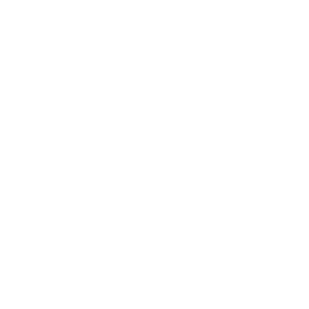

In [0]:
from matplotlib import animation

ims = []
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])

for train_ims in train_images:

    

    im_1 = plt.imshow(train_ims[0,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.ArtistAnimation(fig,ims)
anim.save("test_gif_64.mp4", writer= writer)

(3, 3)


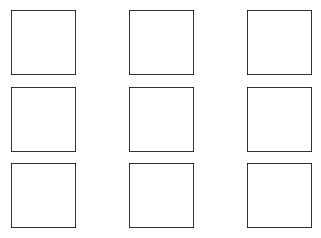

In [0]:
fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in train_images:
    ims = [] 
    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("train_grid.mp4", writer= writer)


In [0]:
noise = generate_latent_points(9)
gen_ims = generator.predict(noise)

gen_ims = (gen_ims + 1) /2.0
for i,im in enumerate(gen_ims):

    plt.subplot(3,3,i+1)
    plt.imshow(im)
plt.show()

NameError: ignored